# Postes- iluminação pública do Recife

##### Este projeto tem como objetivo central a integração e consolidação de três conjuntos de dados da ilumiação pública do Recife (nos anos de 2023, 2024 e 2025). O principal propósito é criar uma base de dados única, coesa e padronizada, que permita análises aprofundadas, consultas complexas e geração de insights relevantes sobre o tema. Para atingir esse objetivo, neste colab, adotamos a técnica de ETL(Extração, Transformação e Carregamento).

##Extracting and configuring libraries

In [87]:
! pip install pandas numpy
import os
import pandas as pd
import numpy as np
import io

In [88]:
# Carregamento de dados
def carregar_arquivo(path, ano):
  if not os.path.exists(path):
      print(f"ERRO: Arquivo não encontrado: {path}")
      return None

  sep = "," if ano == 2023 else ";" # 2023 tem separação ','

  try:
      print(f"Lendo arquivo do ano {ano}: {path} (sep='{sep}')")
      df = pd.read_csv(path, encoding="latin1", sep=sep)
      return df

  except Exception as e:
      print(f"ERRO ao carregar arquivo do ano {ano}: {e}")
      return None



# Padronização de colunas

def padronizar_colunas(df):
    """Padroniza nomes das colunas sem alterar sua lógica original."""

    df.columns = (
        df.columns
            .str.lower()
            .str.normalize("NFKD")
            .str.encode("ascii", errors="ignore")
            .str.decode("utf-8")
            .str.replace(r"[^a-z0-9]+", "_", regex=True)
            .str.strip("_")
    )

    return df


# Extract
arquivos = {
    2023: '/content/cadastro_dezembro_2023_rev02.csv',
    2024: '/content/cadastro-de-ip-recife-31.12.2024.csv',
    2025: '/content/cadastro-de-ip-recife-30.04.2025.csv'
}

lista_dataframes = []

colunas_essenciais = ["id_ponto", "localizacao", "tipo_poste"]

for ano, caminho in arquivos.items():

    df = carregar_arquivo(caminho, ano)

    if df is None:
        continue

    df = padronizar_colunas(df)


    df["ano_original"] = ano
    lista_dataframes.append(df)


# Concatenação Final
df = pd.concat(lista_dataframes, ignore_index=True)

print(f"Concat final realizado — total de linhas: {len(df)}")


Lendo arquivo do ano 2023: /content/cadastro_dezembro_2023_rev02.csv (sep=',')
Lendo arquivo do ano 2024: /content/cadastro-de-ip-recife-31.12.2024.csv (sep=';')
Lendo arquivo do ano 2025: /content/cadastro-de-ip-recife-30.04.2025.csv (sep=';')
Concat final realizado — total de linhas: 329146


## Transformation

In [89]:
display(df.head())

,id_ponto,sequencia,rpa,localizaca,endereco,barramento,latitude,longitude,bairro,medicao,...,potencia_1,perdas_1,total_ca_1,consumo_1,atualizaa,bloq_amp,ano_original,barrament0,atualizaca,iid_ponto
0,264225073.0,11.0,6,Ponte,Governador Paulo Guerra,B001539D,-8.083426,-34.890112,Pina,SIM,...,211,0,211,72.69,NaN,NaN,2023,NaN,NaN,NaN
1,264231536.0,21.0,6,Ponte,Engenheiro Anotoino De Goes,B010454D,-8.082644,-34.889309,Pina,SIM,...,150,0,150,51.675,NaN,NaN,2023,NaN,NaN,NaN
2,264231536.0,21.0,6,Ponte,Engenheiro Anotoino De Goes,B010454D,-8.082644,-34.889309,Pina,SIM,...,150,0,150,51.675,NaN,NaN,2023,NaN,NaN,NaN
3,264290462.0,12.0,5,Rua,Pe-008,B017741D,-8.078685,-34.902353,Afogados,NÃO,...,40,0,40,13.78,NaN,NaN,2023,NaN,NaN,NaN
4,268830784.0,1.0,1,Avenida,Agamenon Magalhaes,B029715,-8.038548,-34.875048,Santo Amaro,NÃO,...,90,0,90,31.005,NaN,NaN,2023,NaN,NaN,NaN


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329146 entries, 0 to 329145
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_ponto      209717 non-null  float64
 1   sequencia     314068 non-null  float64
 2   rpa           329146 non-null  int64  
 3   localizaca    329143 non-null  object 
 4   endereco      329146 non-null  object 
 5   barramento    106935 non-null  object 
 6   latitude      329146 non-null  object 
 7   longitude     329146 non-null  object 
 8   bairro        329146 non-null  object 
 9   medicao       329146 non-null  object 
 10  tipo_lumin    329146 non-null  object 
 11  tipo_de_po    329137 non-null  object 
 12  tipo_lampa    329146 non-null  object 
 13  qtde          329146 non-null  int64  
 14  potencia      329146 non-null  int64  
 15  perdas        329146 non-null  int64  
 16  total_carg    329146 non-null  int64  
 17  consumo_kw    329146 non-null  object 
 18  pote

In [91]:
#Padronização de colunas

if 'barrament0' in df.columns:
    df['barramento'] = df['barramento'].fillna(df['barrament0'])

df['data_modernizacao_led'] = pd.Series(dtype='object')
for col in ['atualizac', 'atualizaca', 'atualizaa']:
    if col in df.columns:
        df['data_modernizacao_led'] = df['data_modernizacao_led'].fillna(df[col])
df = df.drop(columns=['atualizac', 'atualizaca', 'atualizaa'], errors='ignore')


if 'consumo_1' in df.columns:
    df['consumo_kwh'] = df['consumo_kw'].fillna(df['consumo_1'])
else:
    df['consumo_kwh'] = df['consumo_kw']


if 'perdas_1' in df.columns:
    df['perdas'] = df['perdas'].fillna(df['perdas_1'])

if 'id_ponto' in df.columns and 'iid_ponto' in df.columns:
    df['id_ponto'] = df['id_ponto'].fillna(df['iid_ponto'])
    df = df.drop(columns=['iid_ponto'])


if 'potencia_1' in df.columns:
    df['potencia'] = df['potencia'].fillna(df['potencia_1'])


if 'total_ca_1' in df.columns:
    df['total_carga'] = df['total_carg'].fillna(df['total_ca_1'])
else:
    df['total_carga'] = df['total_carg']


columns_to_drop = [
    'barrament0',
    'consumo_kw', 'consumo_1',
    'perdas_1',
    'potencia_1',
    'total_carg', 'total_ca_1'
]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)



df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')


df['consumo_kwh'] = (
    df['consumo_kwh']
    .astype(str)
    .str.replace(',', '.')
)
df['consumo_kwh'] = pd.to_numeric(df['consumo_kwh'], errors='coerce')

df['data_modernizacao_led'] = pd.to_datetime(df['data_modernizacao_led'], errors='coerce', dayfirst=True)

In [92]:
df.nunique(dropna=False)

,0
id_ponto,90897
sequencia,455
rpa,6
localizaca,93
endereco,12129
barramento,76561
latitude,69622
longitude,59216
bairro,197
medicao,3


### Tratamento de valores faltantes

In [93]:
print("Valores ausentes por coluna:")
print(df.isnull().sum())

Valores ausentes por coluna:
id_ponto                  14862
sequencia                 15078
rpa                           0
localizaca                    3
endereco                      0
barramento                  150
latitude                 222135
longitude                222136
bairro                        0
medicao                       0
tipo_lumin                    0
tipo_de_po                    9
tipo_lampa                    0
qtde                          0
potencia                      0
perdas                        0
bloq_amp                 328873
ano_original                  0
data_modernizacao_led    279628
consumo_kwh                   0
total_carga                   0
dtype: int64


###Decisões de tratamento


-  O bloq_amp não tem praticamente nenhum valor válido que possa ser usado para generalizações, além de não aparecer no dicionário de dados da prefeitura. Remoção.
- Em id_ponto, não é possível acompanhar o ciclo de vida, manutenção ou desempenho (KPIs) desse ponto. Remover esses registros é um preço pequeno a pagar para garantir que todo o restante do dataset tenha uma base de identificação sólida e confiável.
- Sequência - Vou substituir pela Mediana, porque é o valor central em um conjunto de dados ordenados. É a escolha mais robusta para sequencia por ser resistente a outliers (valores extremos), ao contrário da Média, e mais representativa do que a Moda (o valor mais frequente) em uma distribuição que pode ser discreta ou contínua. Esse dado é muito valioso para futuras análises e não seria interessante perdê-lo.
- O ID 0.0 está identificando 4 pontos diferentes. Gerei ids diferentes para os 4 pontos, substituindo o 0.0 ou remover. decidir em reunião.

In [94]:
#print coluna com id 0.0

df[df['id_ponto'] == 0.0]

,id_ponto,sequencia,rpa,localizaca,endereco,barramento,latitude,longitude,bairro,medicao,...,tipo_de_po,tipo_lampa,qtde,potencia,perdas,bloq_amp,ano_original,data_modernizacao_led,consumo_kwh,total_carga
63912,0.0,25.0,5,Travessa,1 Professor Joaquim Amazonas,B081218,-8.098663,-34.960914,Barro,NÃO,...,POSTE COMUM,LED,1,70,0,NaN,2023,2021-12-21,8.040000e-01,70
64201,0.0,3.0,5,Travessa,3 Professor Joaquim Amazonas,B081281,-8.097447,-34.961749,Barro,NÃO,...,POSTE COMUM,LED,1,70,0,NaN,2023,2021-12-21,8.040000e-01,70
64202,0.0,4.0,5,Travessa,3 Professor Joaquim Amazonas,C356468,-8.097466,-34.961611,Barro,NÃO,...,POSTE COMUM,LED,1,70,0,NaN,2023,2021-12-21,8.040000e-01,70
64203,0.0,2.0,5,Travessa,3 Professor Joaquim Amazonas,B081280,-8.097368,-34.962019,Barro,NÃO,...,POSTE COMUM,LED,1,70,0,NaN,2023,2021-12-21,8.040000e-01,70
76314,0.0,11.0,5,Travessa,Professor Simoes Barbosa,B080323,-8.098298,-34.960759,Barro,NÃO,...,POSTE COMUM,LED,1,70,0,NaN,2023,2021-12-21,8.040000e-01,70
77658,0.0,13.0,5,Travessa,Rondonopolis,B069025,-8.090900,-34.946130,Barro,NÃO,...,POSTE COMUM,LED,1,30,0,NaN,2023,2021-10-25,3.450000e-01,30
77659,0.0,14.0,5,Travessa,Rondonopolis,B069026,-8.091103,-34.946128,Barro,NÃO,...,POSTE COMUM,LED,1,30,0,NaN,2023,2021-10-25,3.450000e-01,30
77666,0.0,16.0,5,Travessa,Rondonopolis,H026217D,-8.091195,-34.946232,Barro,NÃO,...,POSTE COMUM,LED,1,30,0,NaN,2023,2021-10-25,3.450000e-01,30
77667,0.0,16.0,5,Travessa,Rondonopolis,H026217D,-8.091195,-34.946232,Barro,NÃO,...,POSTE COMUM,LED,1,30,0,NaN,2023,2021-10-25,3.450000e-01,30
79187,0.0,8.0,5,Avenida,Tapajos,B082501,-8.092885,-34.925256,Areias,NÃO,...,POSTE COMUM,LED,1,70,0,NaN,2023,2021-10-18,8.040000e-01,70


In [95]:
# Remoção das linhas com ID '0', pois são inúmeros locais, dificultando a 'geração superficial' de novos IDs e não é uma perda significativa para o dataset

df = df[df['id_ponto'] != 0.0]


In [96]:
#  Remover registros sem ponto
df = df[df['id_ponto'].notna()]

#Substituição por mediana
mediana = df['sequencia'].median()
df['sequencia'] = df['sequencia'].fillna(mediana)


# Preencher campos opcionais
df['tipo_de_po'] = df['tipo_de_po'].fillna('Não informado')
df['localizaca'] = df['localizaca'].fillna('Não informado')
df['barramento'] = df['barramento'].fillna('Não informado')

# Colunas quase totalmente vazias: removi
df = df.drop(columns=['bloq_amp'], errors='ignore')


### Mudanças especiais no dataset

- Escolhi pela remoção das colunas 'longitude' e 'latitude', já que a localização pode ser obtida através de outros dados (bairro, endereco, localizacao), tornando opcional a existência das duas colunas com tantos valores ausentes.
 - A coluna data_modernizacao_led tem um ponto muito importante, pois no dicionário ela é a "Data da qual este ponto foi modernizado para tecnologia LED", o que abre espaço para inferência: será que o poste não foi atualizado ou realmente há ausência de valores? Não podemos assumir um achismo como verdade, isso ameaça a confiabilidade dos dados. No entanto, assume-se que a coluna é importante para entender esse processo de atualização na Cidade do Recife. Assim, a decisão é substituir os valores nulos por 'NAO_REGISTRADO_MODERNIZACAO". *Entrar em contato com a emlurb

In [97]:
# Dropando colunas

df = df.drop(columns=['latitude', 'longitude'])



# Tratamento data_modernizacao_led

coluna_data_modernizacao_led = 'data_modernizacao_led'
STRING_IMPUTACAO = 'NAO_REGISTRADO_MODERNIZACAO'

if coluna_data_modernizacao_led in df.columns:
    df[coluna_data_modernizacao_led] = df[coluna_data_modernizacao_led].fillna(STRING_IMPUTACAO)
    print(f"-> '{coluna_data_modernizacao_led}' preenchida com a string '{STRING_IMPUTACAO}'.")

    # Tenta converter as datas válidas para o formato datetime.
    def to_datetime_if_valid(date_str):
        if date_str == STRING_IMPUTACAO:
            return date_str
        try:
            return pd.to_datetime(date_str, errors='coerce', dayfirst=True)
        except:
            return date_str

    df[coluna_data_modernizacao_led] = df[coluna_data_modernizacao_led].apply(to_datetime_if_valid)

else:
    print(f"A coluna '{coluna_data_modernizacao_led}' não foi encontrada no DataFrame.")

-> 'data_modernizacao_led' preenchida com a string 'NAO_REGISTRADO_MODERNIZACAO'.


###Consistência e Padronização de Dados Categóricos

In [98]:
df.nunique(dropna=False)

,0
id_ponto,90895
sequencia,454
rpa,6
localizaca,31
endereco,11418
barramento,75217
bairro,121
medicao,3
tipo_lumin,19
tipo_de_po,12


In [99]:
print("\nValores únicos na coluna 'tipo_de_po':\n", df['tipo_de_po'].unique())


Valores únicos na coluna 'tipo_de_po':
 ['POSTE CIRCULAR' 'POSTE COMUM' 'POSTE MADEIRA' 'ORNAMENTAL' 'CIRCULAR'
 'POSTE PARTICULAR' 'POSTE DE FIBRA' 'DESATIVADO' 'PARTICULAR' 'PAREDE'
 'GIRAFA' 'POSTE DE CONCRETO']


In [100]:
print("\nValores únicos na coluna 'localizaca':\n", df['localizaca'].unique())


Valores únicos na coluna 'localizaca':
 ['Ponte' 'Rua' 'Avenida' 'Travessa' 'Viaduto' 'PraÃ§a' 'Largo' 'Rodovia'
 'Beco' 'Condominio' 'Parque' 'Estrada' 'Fazenda' 'Vila' 'Aterro'
 'Conjunto' 'Não informado' 'Alameda' 'Logradouro' 'Subida'
 'Quadra Esporte' 'Quadra' 'Tunel' 'Caminho' 'Campo Futebol' 'Passarela'
 'Praça' 'Cais' 'Obelisco' 'Academia Da Cidade' 'Travessa Dos Jasmin']


In [101]:
print("\nValores únicos na coluna 'medicao':\n", df['medicao'].unique())


Valores únicos na coluna 'medicao':
 ['SIM' 'NÃ\x83O' 'NÃO']


In [102]:
print("\nValores únicos na coluna 'perdas':\n", df['tipo_lumin'].unique())


Valores únicos na coluna 'perdas':
 ['LUMINARIA FECHADA' 'LUMINARIA ABERTA' 'REFLETOR' 'PÃ\x89TALA' 'GLOBO'
 'LAMPIÃ\x83O' 'ARANDELA' 'PAREDE' 'PISO DECORATIVO' 'CANTEIRO CENTRAL'
 'BRAÃ\x87O ORNAMENTAL' 'FECHADA' 'LUMINARIA' 'PÉTALA' 'LAMPIÃO'
 'BRAÇO ORNAMENTAL' 'LUMINARIAFECHADA' 'LUMINÁRIA FECHADA'
 'LUMINÃ\x81RIA FECHADA']


In [103]:
import unicodedata

def normalizar_texto(x):
    if pd.isna(x):
        return x
    x = unicodedata.normalize("NFKD", str(x))
    x = x.encode("ascii", errors="ignore").decode("utf-8")
    x = x.upper().strip()
    return x


# colunas de normalizacao
colunas_texto = ["medicao", "tipo_lumin", "tipo_de_po", "bairro", "localizaca", "tipo_de_po"]

# Normaliza TODAS elas em um loop só
for col in colunas_texto:
    if col in df.columns:
        df[col] = df[col].astype(str).apply(normalizar_texto)


# Correções ESPECÍFICAS

# Correção de SIM / NÃO
df["medicao"] = df["medicao"].replace({
    "NAO": "NAO",
    "SIM": "SIM"
})

df["tipo_lumin"] = df["tipo_lumin"].replace({
    "LUMINARIAFECHADA": "LUMINARIA FECHADA",
    "FECHADA": "LUMINARIA FECHADA",
    "LUMINARIA": "LUMINARIA FECHADA",
    "LUMINARIA ABERTA": "LUMINARIA ABERTA",
    "LAMPIAO": "LAMPIAO",  # garante sem acento
    "PATALA": "PETALA",
    "BRAAO ORNAMENTAL": "BRACO ORNAMENTAL",
})

df["tipo_de_po"] = df["tipo_de_po"].replace({
    "POSTE CIRCULAR": "CIRCULAR",
    "POSTE COMUM": "COMUM",
    "POSTE MADEIRA": "MADEIRA",
    "POSTE PARTICULAR": "PARTICULAR",
    "POSTE DE FIBRA": "FIBRA",
    "POSTE DE CONCRETO": "CONCRETO",
})

df['localizaca'] = df['localizaca'].replace({"PRAAA": "PRACA"})
df = df.rename(columns={"tipo_lampa": "tipo_lampada"})



In [104]:
print("\nValores únicos na coluna 'tipo_de_poste':\n", df['tipo_de_po'].unique())
df = df.rename(columns={"tipo_de_po": "tipo_de_poste"})


Valores únicos na coluna 'tipo_de_poste':
 ['CIRCULAR' 'COMUM' 'MADEIRA' 'ORNAMENTAL' 'PARTICULAR' 'FIBRA'
 'DESATIVADO' 'PAREDE' 'GIRAFA' 'CONCRETO']


In [105]:
df["tipo_lumin"].unique()


array(['LUMINARIA FECHADA', 'LUMINARIA ABERTA', 'REFLETOR', 'PETALA',
       'GLOBO', 'LAMPIAO', 'ARANDELA', 'PAREDE', 'PISO DECORATIVO',
       'CANTEIRO CENTRAL', 'BRACO ORNAMENTAL'], dtype=object)

In [106]:
print("\nValores únicos na coluna 'localizacao':\n", df['localizaca'].unique())
df = df.rename(columns={"localizaca": "localizacao"})



Valores únicos na coluna 'localizacao':
 ['PONTE' 'RUA' 'AVENIDA' 'TRAVESSA' 'VIADUTO' 'PRACA' 'LARGO' 'RODOVIA'
 'BECO' 'CONDOMINIO' 'PARQUE' 'ESTRADA' 'FAZENDA' 'VILA' 'ATERRO'
 'CONJUNTO' 'NAO INFORMADO' 'ALAMEDA' 'LOGRADOURO' 'SUBIDA'
 'QUADRA ESPORTE' 'QUADRA' 'TUNEL' 'CAMINHO' 'CAMPO FUTEBOL' 'PASSARELA'
 'CAIS' 'OBELISCO' 'ACADEMIA DA CIDADE' 'TRAVESSA DOS JASMIN']


In [107]:
print("\nValores únicos na coluna 'medicao':\n", df['medicao'].unique())


Valores únicos na coluna 'medicao':
 ['SIM' 'NAO']


### Tratamento de valores duplicados

In [108]:
print(f"Linhas antes de remover duplicatas: {len(df)}")

todas_colunas = df.columns.tolist()

colunas_para_verificar = [coluna for coluna in todas_colunas if coluna != "id_ponto"] #dúvida

total_duplicatas = df.duplicated(subset=colunas_para_verificar, keep='first').sum()

print(f"Total de linhas duplicadas: {total_duplicatas}")

df = df.drop_duplicates(subset=colunas_para_verificar, keep='first')

print(f"Linhas DEPOIS de remover duplicatas: {len(df)}")

Linhas antes de remover duplicatas: 314251
Total de linhas duplicadas: 34347
Linhas DEPOIS de remover duplicatas: 279904


##Resultado final

In [109]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 279904 entries, 0 to 328046
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_ponto               279904 non-null  float64
 1   sequencia              279904 non-null  float64
 2   rpa                    279904 non-null  int64  
 3   localizacao            279904 non-null  object 
 4   endereco               279904 non-null  object 
 5   barramento             279904 non-null  object 
 6   bairro                 279904 non-null  object 
 7   medicao                279904 non-null  object 
 8   tipo_lumin             279904 non-null  object 
 9   tipo_de_poste          279904 non-null  object 
 10  tipo_lampada           279904 non-null  object 
 11  qtde                   279904 non-null  int64  
 12  potencia               279904 non-null  int64  
 13  perdas                 279904 non-null  int64  
 14  ano_original           279904 non-null  i

None

,id_ponto,sequencia,rpa,localizacao,endereco,barramento,bairro,medicao,tipo_lumin,tipo_de_poste,tipo_lampada,qtde,potencia,perdas,ano_original,data_modernizacao_led,consumo_kwh,total_carga
0,264225073.0,11.0,6,PONTE,Governador Paulo Guerra,B001539D,PINA,SIM,LUMINARIA FECHADA,CIRCULAR,LED,1,211,0,2023,NAO_REGISTRADO_MODERNIZACAO,2.423,211
1,264231536.0,21.0,6,PONTE,Engenheiro Anotoino De Goes,B010454D,PINA,SIM,LUMINARIA FECHADA,CIRCULAR,LED,1,150,0,2023,NAO_REGISTRADO_MODERNIZACAO,1.723,150
3,264290462.0,12.0,5,RUA,Pe-008,B017741D,AFOGADOS,NAO,LUMINARIA FECHADA,CIRCULAR,LED,1,40,0,2023,NAO_REGISTRADO_MODERNIZACAO,0.459,40
4,268830784.0,1.0,1,AVENIDA,Agamenon Magalhaes,B029715,SANTO AMARO,NAO,LUMINARIA FECHADA,COMUM,LED,1,90,0,2023,NAO_REGISTRADO_MODERNIZACAO,1.034,90
5,268830788.0,1.0,1,RUA,Capitao Lima,B021646,SANTO AMARO,NAO,LUMINARIA FECHADA,COMUM,LED,1,90,0,2023,NAO_REGISTRADO_MODERNIZACAO,1.034,90


# Load: Dataset no Banco de Dados PostgreSQL

In [110]:
!pip install sqlalchemy
!pip install psycopg2-binary

###Transformação para um esquema estrela

Granularidade: Uma linha representa a medição e o consumo de um Ponto de Iluminação (id_ponto) em um determinado Ano de Coleta e com uma Data de Atualização registrada.


Criação das dimensões:

- Dimensão Poste/Equipamento (id_ponto,sequencia, tipo_luminaria, tipo_poste, barramento, medicao)
- Dimensão Localidade (rpa, bairro, endereco, localizacao)
- Dimensão tempo (data_modernizacao_led, dia, mes, ano, trimestre, dia_da_semana)
- Dimensão origem (ano_original, descricao_origem)

In [111]:
# Criação das dimensões

# Criação da dimensão poste
colunas_poste = ['id_ponto', 'sequencia', 'tipo_lumin', 'tipo_de_poste', 'tipo_lampada','barramento', 'medicao']
dim_poste = df[colunas_poste].drop_duplicates().reset_index(drop=True)
dim_poste = dim_poste.reset_index().rename(columns={'index': 'id_poste_sk'})

print(f"Dimensão Poste/Equipamento: {len(dim_poste)} postes")

#Criação da dimensão localidade
colunas_localidade = ['rpa', 'bairro', 'endereco', 'localizacao']
dim_localidade = df[colunas_localidade].drop_duplicates().reset_index(drop=True)
dim_localidade = dim_localidade.reset_index().rename(columns={'index': 'id_localidade_sk'})

print(f"Dimensão Localidade: {len(dim_localidade)}")

# Criação da dimensão tempo
datas_validas = df[df['data_modernizacao_led'] != STRING_IMPUTACAO]['data_modernizacao_led'].drop_duplicates().copy()
datas_validas = pd.to_datetime(datas_validas, errors='coerce').dropna().sort_values().reset_index(drop=True)

dim_tempo_validas = pd.DataFrame(datas_validas, columns=['data_modernizacao_led'])
dim_tempo_validas['dia'] = dim_tempo_validas['data_modernizacao_led'].dt.day
dim_tempo_validas['mes'] = dim_tempo_validas['data_modernizacao_led'].dt.month
dim_tempo_validas['ano'] = dim_tempo_validas['data_modernizacao_led'].dt.year
dim_tempo_validas['trimestre'] = dim_tempo_validas['data_modernizacao_led'].dt.quarter
dim_tempo_validas['dia_semana'] = dim_tempo_validas['data_modernizacao_led'].dt.day_name()


special_row_nao_registrado = pd.DataFrame({
    'data_modernizacao_led': [STRING_IMPUTACAO],
    'dia': [pd.NA],
    'mes': [pd.NA],
    'ano': [pd.NA],
    'trimestre': [pd.NA],
    'dia_semana': [pd.NA]
})


dim_tempo = pd.concat([special_row_nao_registrado, dim_tempo_validas], ignore_index=True)
dim_tempo = dim_tempo.reset_index().rename(columns={'index': 'id_tempo_sk'})

print(f"Dimensão Tempo (incluindo 'NAO_REGISTRADO_MODERNIZACAO') criada: {len(dim_tempo)} registros.")

# Criação da dimensão origem
colunas_origem = ['ano_original']
dim_origem = df[colunas_origem].drop_duplicates().reset_index(drop=True)
# Adiciona a Chave Substituta (SK)
dim_origem = dim_origem.reset_index().rename(columns={'index': 'id_origem_sk'})
# Adiciona o atributo descritivo
dim_origem['descricao_origem'] = 'Cadastro de IP Recife - Ano ' + dim_origem['ano_original'].astype(str)
print(f"Dimensão Origem criada: {len(dim_origem)} registros.")



Dimensão Poste/Equipamento: 93282 postes
Dimensão Localidade: 15294
Dimensão Tempo (incluindo 'NAO_REGISTRADO_MODERNIZACAO') criada: 265 registros.
Dimensão Origem criada: 3 registros.


In [112]:
#criação da tabela fato

fato = df.merge(dim_poste, on = colunas_poste, how = 'left')
fato = fato.merge(dim_localidade, on = colunas_localidade, how = 'left')
fato = fato.merge(dim_tempo, on = 'data_modernizacao_led', how = 'left')
fato = fato.merge(dim_origem, on = colunas_origem, how = 'left')


colunas_fato = [
    'id_poste_sk',          # Chave Estrangeira para a DIM_POSTE_EQUIPAMENTO
    'id_localidade_sk',     # Chave Estrangeira para a DIM_LOCALIDADE
    'id_tempo_sk',          # Chave Estrangeira para a DIM_TEMPO
    'id_origem_sk',

    'qtde',          # Quantidade de luminárias instaladas
    'potencia',         # Potência elétrica da lâmpada (W)
    'perdas',         # Potência referente às perdas elétricas
    'total_carga',     # Carga elétrica total (Potência + Perdas)
    'consumo_kwh'      # Consumo de energia estimado para 30 dias (kWh)
]


fato_iluminacao = fato[colunas_fato]
print(f"Fato pronta: {len(fato_iluminacao)} registros.")

Fato pronta: 279904 registros.


In [113]:
from sqlalchemy import create_engine

# Configurando a conexão
usuario_db = 'postgres.wbamssbwhweihxxthfnm'                  # Usuário padrão
senha_db = 'bd2025.1'                # Senha
host_db = 'aws-0-us-west-2.pooler.supabase.com'                     # Padrão
porta_db = '5432'                    # Padrão
nome_banco_db = 'postgres'           # O banco criado


# Criando a "connection string"
DATABASE_URL = f'postgresql://{usuario_db}:{senha_db}@{host_db}:{porta_db}/{nome_banco_db}?client_encoding=utf8'


print("Tentando criar conexão com o banco...")

try:
    engine = create_engine(DATABASE_URL)
    print("Conexão bem-sucedida! Iniciando a carga do Esquema Estrela...")

    print("Carregando Dimensão Poste")
    dim_poste.to_sql('dim_poste', con=engine, if_exists='replace', index=False)

    print("Carregando Dimensão Localidade...")
    dim_localidade.to_sql('dim_localidade', con=engine, if_exists='replace', index=False)

    print("Carregando Dimensão Tempo...")
    dim_tempo.to_sql('dim_tempo', con=engine, if_exists='replace', index=False)

    print("Carregando Dimensão Origem...")
    dim_origem.to_sql('dim_origem', con=engine, if_exists='replace', index =False)

    print("Carregando Tabela Fato...")
    fato_iluminacao.to_sql('fato_iluminacao', con=engine, if_exists='replace', index=False)

    print("\nCARGA CONCLUÍDA! Todas as tabelas do Esquema Estrela foram criadas.")

except Exception as e:
    print(f"\n--- ERRO! ---")
    print(f"Erro ao carregar os dados: {e}")

Tentando criar conexão com o banco...
Conexão bem-sucedida! Iniciando a carga do Esquema Estrela...
Carregando Dimensão Poste
Carregando Dimensão Localidade...
Carregando Dimensão Tempo...
Carregando Dimensão Origem...
Carregando Tabela Fato...

CARGA CONCLUÍDA! Todas as tabelas do Esquema Estrela foram criadas.


## Esquema Estrela no POWER BI

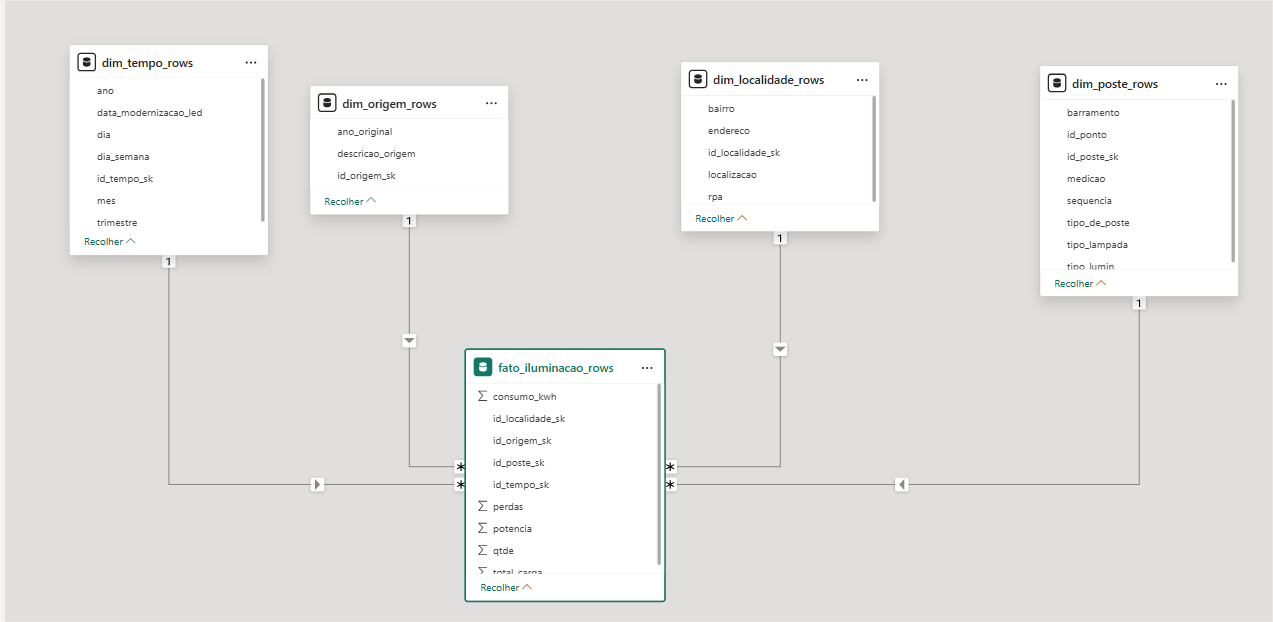